# Lab 10 (Word2Vec)

### Prepare Training Data

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning and info message
import tensorflow as tf
import numpy as np
import random

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices([], 'GPU') # Apple M-1 Pro bug with tensorflow workaround (use CPU)
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 0 Logical GPUs


In [3]:
import os
import urllib

# Download the data.
DOWNLOAD_URL = 'http://mattmahoney.net/dc/'
DATA_FOLDER = "data"
FILE_NAME = "text8.zip"
EXPECTED_BYTES = 31344016

def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass
    
def download(file_name, expected_bytes):
    """ Download the dataset text8 if it's not already downloaded """
    local_file_path = os.path.join(DATA_FOLDER, file_name)
    if os.path.exists(local_file_path):
        print("Dataset ready")
        return local_file_path
    file_name, _ = urllib.request.urlretrieve(os.path.join(DOWNLOAD_URL, file_name), local_file_path)
    file_stat = os.stat(local_file_path)
    if file_stat.st_size == expected_bytes:
        print('Successfully downloaded the file', file_name)
    else:
        raise Exception(
              'File ' + file_name +
              ' might be corrupted. You should try downloading it with a browser.')
    return local_file_path    
    
make_dir(DATA_FOLDER)
file_path = download(FILE_NAME, EXPECTED_BYTES)

Dataset ready


In [4]:
import zipfile

# Read the data into a list of strings.
def read_data(file_path):
    """ Read data into a list of tokens """
    with zipfile.ZipFile(file_path) as f:
        # tf.compat.as_str() converts the input into string
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

vocabulary = read_data(file_path)
print('Data size', len(vocabulary))

Data size 17005207


In [5]:
vocabulary[:5]

['anarchism', 'originated', 'as', 'a', 'term']

### Build Dictionary

In [6]:
import collections
# Build the dictionary and replace rare words with UNK token.
def build_dataset(words, n_words):
    """ Create two dictionaries and count of occuring words
        - word_to_id: map of words to their codes
        - id_to_word: maps codes to words (inverse word_to_id)
        - count: map of words to count of occurrences
    """
    # map unknown words to -1
    count = [['UNK', -1]]
    # count of occurences for words in vocabulary
    count.extend(collections.Counter(words).most_common(n_words - 1)) 
    word_to_id = dict() # (word, id)
    # record word id
    for word, _ in count:
        word_to_id[word] = len(word_to_id)
    id_to_word = dict(zip(word_to_id.values(), word_to_id.keys())) # (id, word)
    return word_to_id, id_to_word, count

def convert_words_to_id(words, dictionary, count):
    """ Replace each word in the dataset with its index in the dictionary """
    data_w2id = []
    unk_count = 0
    for word in words:
        # return 0 if word is not in dictionary
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data_w2id.append(index)
    count[0][1] = unk_count
    return data_w2id, count

In [7]:
"""Filling 4 global variables:
# data_w2id - list of codes (integers from 0 to vocabulary_size-1).
              This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# word_to_id - map of words(strings) to their codes(integers)
# id_to_word - maps codes(integers) to words(strings)
"""

vocabulary_size = 50000
word_to_id, id_to_word, count = build_dataset(vocabulary, vocabulary_size)
data_w2id, count = convert_words_to_id(vocabulary, word_to_id, count)
del vocabulary  # reduce memory.

In [8]:
print('Most common words (+UNK)', count[:5])
print('Sample data: {}'.format(data_w2id[:10]))
print([id_to_word[i] for i in data_w2id[:10]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data: [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [9]:
# utility function
def generate_sample(center_words, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for idx, center in enumerate(center_words):
        context = random.randint(1, context_window_size)
        # get a random target before the center word
        for target in center_words[max(0, idx - context) : idx]:
            yield center, target
        # get a random target after the center word
        for target in center_words[idx + 1 : idx + context + 1]:
            yield center, target

def batch_generator(data, skip_window, batch_size):
    """ Group a numeric stream into batches and yield them as Numpy arrays. """
    single_gen = generate_sample(data, skip_window)
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for idx in range(batch_size):
            center_batch[idx], target_batch[idx] = next(single_gen)
        yield center_batch, target_batch

### Skip-gram word2vec Model

In [10]:
## some training settings
training_steps = 80000
skip_step = 2000

## some hyperparameters
batch_size = 512
embed_size = 512
num_sampled = 256
learning_rate = 1.0

In [11]:
# from tensorflow.keras.layers import Layer
from tensorflow.python.keras.layers import Layer

# embedding matrix - hidden layer
class embedding_lookup(Layer):
    def __init__(self):
        super(embedding_lookup, self).__init__()
        embedding_init = tf.keras.initializers.GlorotUniform()
        self.embedding_matrix = self.add_weight(name="embedding_matrix",
                                                trainable=True,
                                                shape=[vocabulary_size, embed_size],
                                                initializer=embedding_init)

    def call(self, inputs):
        center_words = inputs
        embedding = tf.nn.embedding_lookup(self.embedding_matrix,
                                           center_words, 
                                           name='embedding')
        return embedding

# context matrix - prediction layer
class nce_loss(Layer):
    def __init__(self):
        super(nce_loss, self).__init__()
        nce_w_init = tf.keras.initializers.TruncatedNormal(stddev=1.0/(embed_size ** 0.5))
        self.nce_weight = self.add_weight(name='nce_weight',
                                          trainable=True,
                                          shape=[vocabulary_size, embed_size],
                                          initializer=nce_w_init)
        self.nce_bias = self.add_weight(name='nce_bias',
                                        trainable=True,
                                        shape=[vocabulary_size],
                                        initializer=tf.keras.initializers.Zeros)

    def call(self, inputs):
        embedding, target_words = inputs[0], inputs[1]
        loss = tf.reduce_mean(tf.nn.nce_loss(weights=self.nce_weight, 
                                             biases=self.nce_bias, 
                                             labels=target_words, 
                                             inputs=embedding, 
                                             num_sampled=num_sampled, 
                                             num_classes=vocabulary_size),
                                             name='loss')
        return loss

In [12]:
# from tensorflow.keras import Model, Input
from tensorflow.python.keras import Model, Input

center_words = Input(shape=(), name='center_words', dtype='int32')
target_words = Input(shape=(1), name='target_words', dtype='int32')

embedding = embedding_lookup()(center_words)
loss = nce_loss()((embedding, target_words))

word2vec = Model(name='word2vec',
                 inputs=[center_words, target_words],
                 outputs=[loss])

In [13]:
word2vec.summary()

Model: "word2vec"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
center_words (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
embedding_lookup (embedding_loo (None, 512)          25600000    center_words[0][0]               
__________________________________________________________________________________________________
target_words (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
nce_loss (nce_loss)             ()                   25650000    embedding_lookup[0][0]           
                                                                 target_words[0][0]        

In [14]:
## geneartor for `tf.data.Dataset`
def gen():
    """ Return a python generator that generates batches. """
    yield from batch_generator(data_w2id, 2, batch_size)

    

dataset = tf.data.Dataset.from_generator(gen, 
                                         (tf.int32, tf.int32),
                                         (tf.TensorShape([batch_size]), tf.TensorShape([batch_size, 1])))\
                         .repeat()

In [15]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.1,nesterov=True)

In [16]:
@tf.function
def train_step(center_words, target_words):
    with tf.GradientTape() as tape:
        loss = word2vec([center_words, target_words])
    gradients = tape.gradient(loss, word2vec.trainable_variables)
    optimizer.apply_gradients(zip(gradients, word2vec.trainable_variables))

    train_loss(loss)

In [17]:
x = []
y = []
for step, (center_words, target_words) in enumerate(dataset):
    if step == training_steps:
        break
    train_step(center_words, target_words)

    if ((step+1) % skip_step) == 0:
        template = 'Step {:0}, Loss: {:.2f}'
        x.append(step+1)
        y.append(train_loss.result())
        print(template.format(step+1, train_loss.result()))
        train_loss.reset_states()

Step 2000, Loss: 174.58
Step 4000, Loss: 31.65
Step 6000, Loss: 15.41
Step 8000, Loss: 10.75
Step 10000, Loss: 9.63
Step 12000, Loss: 8.71
Step 14000, Loss: 8.15
Step 16000, Loss: 7.44
Step 18000, Loss: 7.15
Step 20000, Loss: 6.95
Step 22000, Loss: 6.93
Step 24000, Loss: 6.72
Step 26000, Loss: 6.57
Step 28000, Loss: 6.42
Step 30000, Loss: 6.44
Step 32000, Loss: 6.38
Step 34000, Loss: 6.26
Step 36000, Loss: 6.24
Step 38000, Loss: 6.14
Step 40000, Loss: 6.15
Step 42000, Loss: 6.11
Step 44000, Loss: 5.93
Step 46000, Loss: 5.94
Step 48000, Loss: 5.98
Step 50000, Loss: 5.90
Step 52000, Loss: 5.88
Step 54000, Loss: 5.95
Step 56000, Loss: 5.89
Step 58000, Loss: 5.85
Step 60000, Loss: 5.92
Step 62000, Loss: 5.82
Step 64000, Loss: 5.81
Step 66000, Loss: 5.90
Step 68000, Loss: 5.80
Step 70000, Loss: 5.74
Step 72000, Loss: 5.82
Step 74000, Loss: 5.78
Step 76000, Loss: 5.45
Step 78000, Loss: 5.61
Step 80000, Loss: 5.72


Fontconfig warning: ignoring UTF-8: not a valid region tag


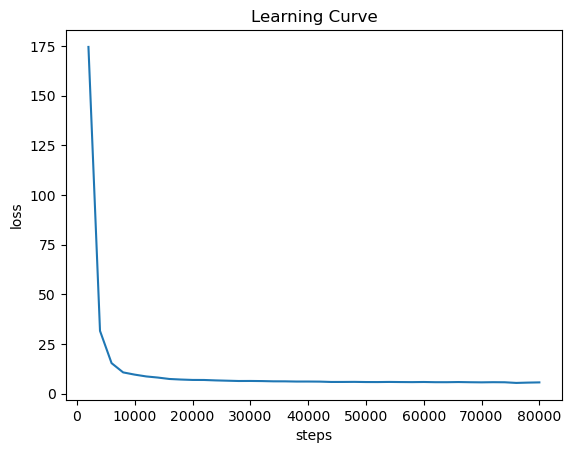

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.xlabel("steps")
plt.ylabel("loss")
plt.title("Learning Curve")
plt.plot(x, y)
plt.show()

### Visualizing the learned embeddings

In [19]:
# get embedding matrix from model weights. > word2vec.weights[0]
embedding_matrix = word2vec.weights[0]

In [20]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18), dpi=150)  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

/Users/jadenliu/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


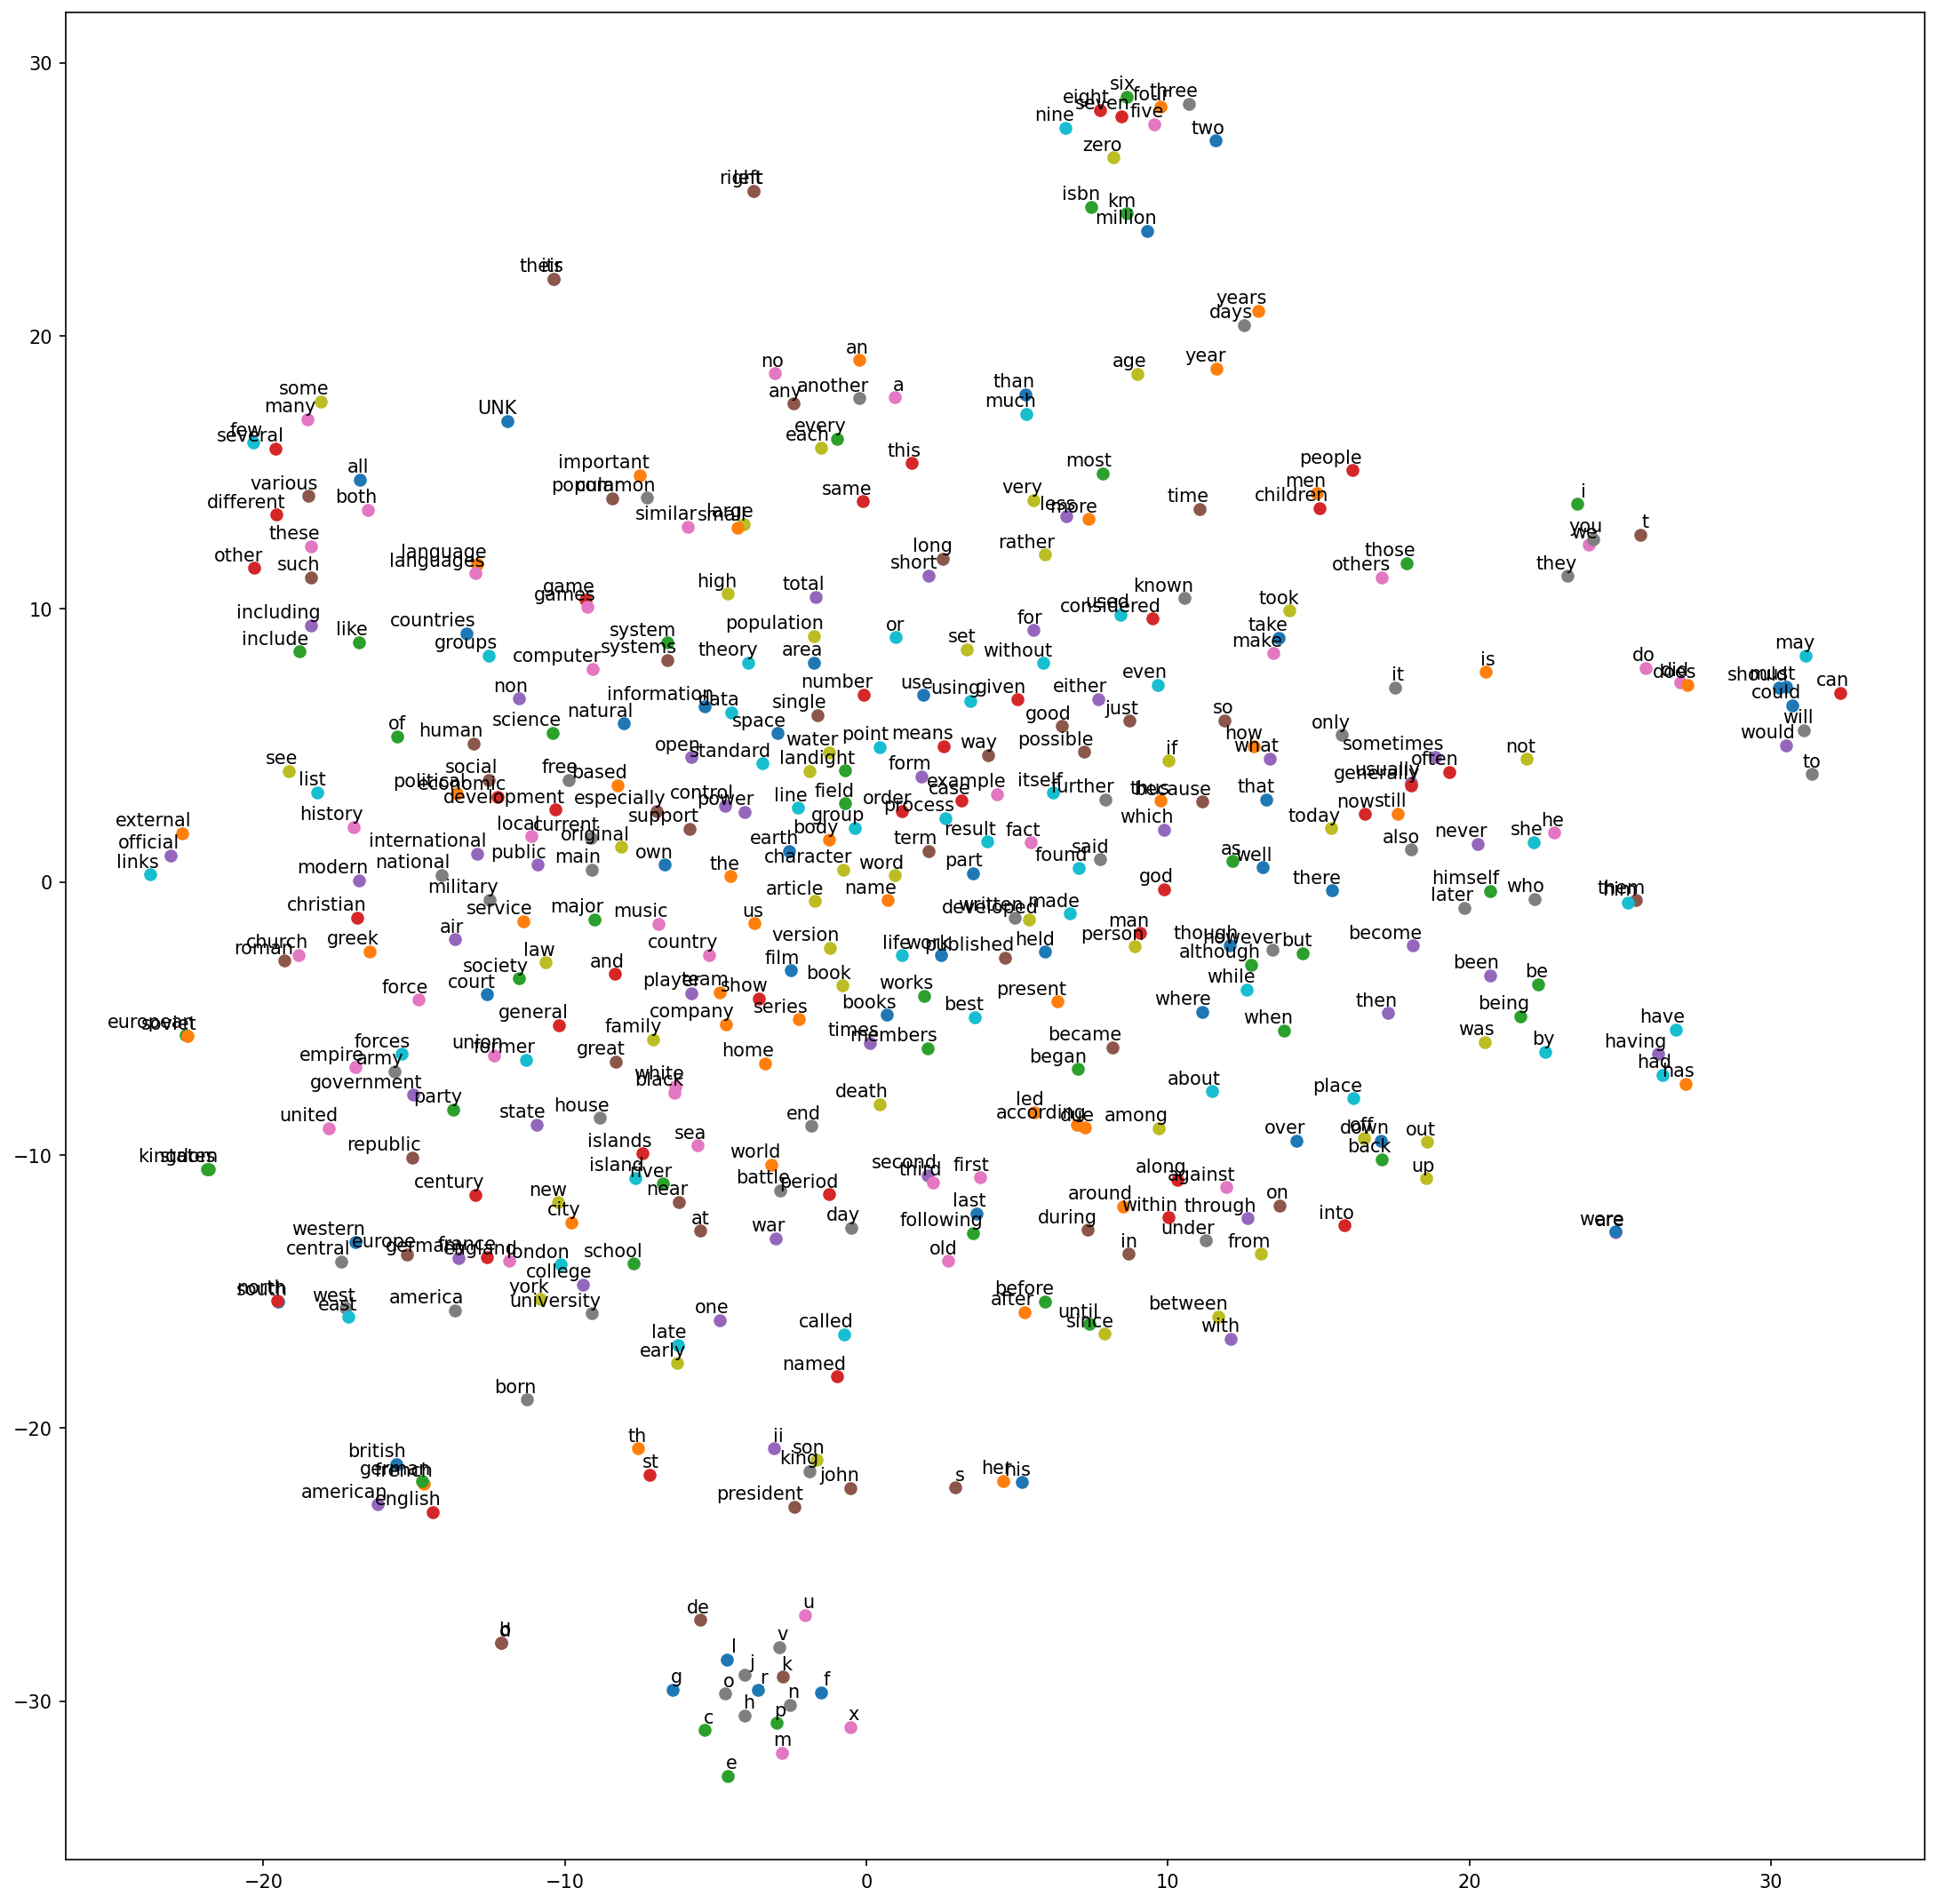

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact', learning_rate='auto')
plot_only = 400
final_embeddings = embedding_matrix
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [id_to_word[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

### Cosine Similarity

In [22]:
import numpy.linalg as LA

In [23]:
# handy method for calculating the similarity between 2 word
def cos_sim(word1, word2):
    id1 = word_to_id[word1]
    id2 = word_to_id[word2]
    
    vec1 = embedding_matrix[id1].numpy()
    vec2 = embedding_matrix[id2].numpy()

    return np.dot(vec1, vec2) / (LA.norm(vec1) * LA.norm(vec2))

In [24]:
cos_sim('cat', 'dog'), cos_sim('man', 'woman')

(0.9862376, 0.9333875)

In [25]:
def top_k_nearest(word, k):
    vec = embedding_matrix[word_to_id[word]]
    
    # calaulate cosine similarity  of `vec` and all other vocabularies
    dot = np.dot(embedding_matrix.numpy(), vec)
    embedding_norm = LA.norm(embedding_matrix.numpy(), axis=-1)
    vec_norm = LA.norm(vec)
    norm_product = embedding_norm * vec_norm
    cos_sim = dot / norm_product
    
    # print out top k nearest words
    indices = np.argsort(cos_sim)[::-1][:k]
    print('---top {} nearest words of {}---'.format(k, word))
    for idx in indices:
        print(id_to_word[idx])
    print('\n')

In [26]:
top_k_nearest('england', 5)
top_k_nearest('rock', 5)

---top 5 nearest words of england---
england
spain
scotland
italy
mexico


---top 5 nearest words of rock---
rock
pop
jazz
dance
folk




### 1. Devise Word2Vec model by subclassing keras.Model

In [88]:
# from tensorflow.keras import Model
from tensorflow.python.keras import Model

class Word2Vec(Model):
    def __init__(self):
        super(Word2Vec, self).__init__()
        self.context_layer = embedding_lookup()
        self.loss_layer = nce_loss()
        
    def call(self, center_words, target_words):
        center = self.context_layer(center_words)
        loss = self.loss_layer((center, target_words))

        return loss

### 2. Train your word2vec model and plot your learning curve

In [89]:
# Create model
model = Word2Vec()

In [90]:
# Define loss function and optimizer
train_loss = tf.keras.metrics.Mean(name='train_loss')
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.1,nesterov=True)

In [91]:
@tf.function
def train_step(center_words, target_words):
    with tf.GradientTape() as tape:
        loss = model(center_words, target_words)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)

In [92]:
## some training settings
training_steps = 80000
skip_step = 2000

## some hyperparameters
batch_size = 512
embed_size = 512
num_sampled = 256
learning_rate = 1.0

In [93]:
# Train model
x = []
y = []
for step, (center_words, target_words) in enumerate(dataset):
    if step == training_steps:
        break
    train_step(center_words, target_words)

    if ((step+1) % skip_step) == 0:
        template = 'Step {:0}, Loss: {:.2f}'
        x.append(step+1)
        y.append(train_loss.result())
        print(template.format(step+1, train_loss.result()))
        train_loss.reset_states()

Step 2000, Loss: 174.66
Step 4000, Loss: 31.49
Step 6000, Loss: 15.52
Step 8000, Loss: 10.72
Step 10000, Loss: 9.63
Step 12000, Loss: 8.70
Step 14000, Loss: 8.09
Step 16000, Loss: 7.45
Step 18000, Loss: 7.15
Step 20000, Loss: 7.02
Step 22000, Loss: 6.89
Step 24000, Loss: 6.76
Step 26000, Loss: 6.57
Step 28000, Loss: 6.42
Step 30000, Loss: 6.45
Step 32000, Loss: 6.38
Step 34000, Loss: 6.26
Step 36000, Loss: 6.24
Step 38000, Loss: 6.17
Step 40000, Loss: 6.13
Step 42000, Loss: 6.11
Step 44000, Loss: 5.94
Step 46000, Loss: 5.95
Step 48000, Loss: 5.98
Step 50000, Loss: 5.89
Step 52000, Loss: 5.87
Step 54000, Loss: 5.97
Step 56000, Loss: 5.88
Step 58000, Loss: 5.84
Step 60000, Loss: 5.92
Step 62000, Loss: 5.82
Step 64000, Loss: 5.81
Step 66000, Loss: 5.90
Step 68000, Loss: 5.81
Step 70000, Loss: 5.75
Step 72000, Loss: 5.84
Step 74000, Loss: 5.78
Step 76000, Loss: 5.44
Step 78000, Loss: 5.60
Step 80000, Loss: 5.71


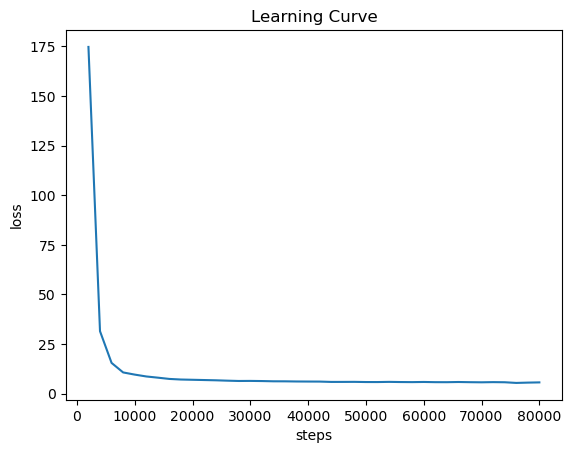

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.xlabel("steps")
plt.ylabel("loss")
plt.title("Learning Curve")
plt.plot(x, y)
plt.show()

### 3. Visualize your embedding matrix by t-SNE

In [95]:
# get embedding matrix from model weights. > word2vec.weights[0]
embedding_matrix = model.weights[0]

/Users/jadenliu/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


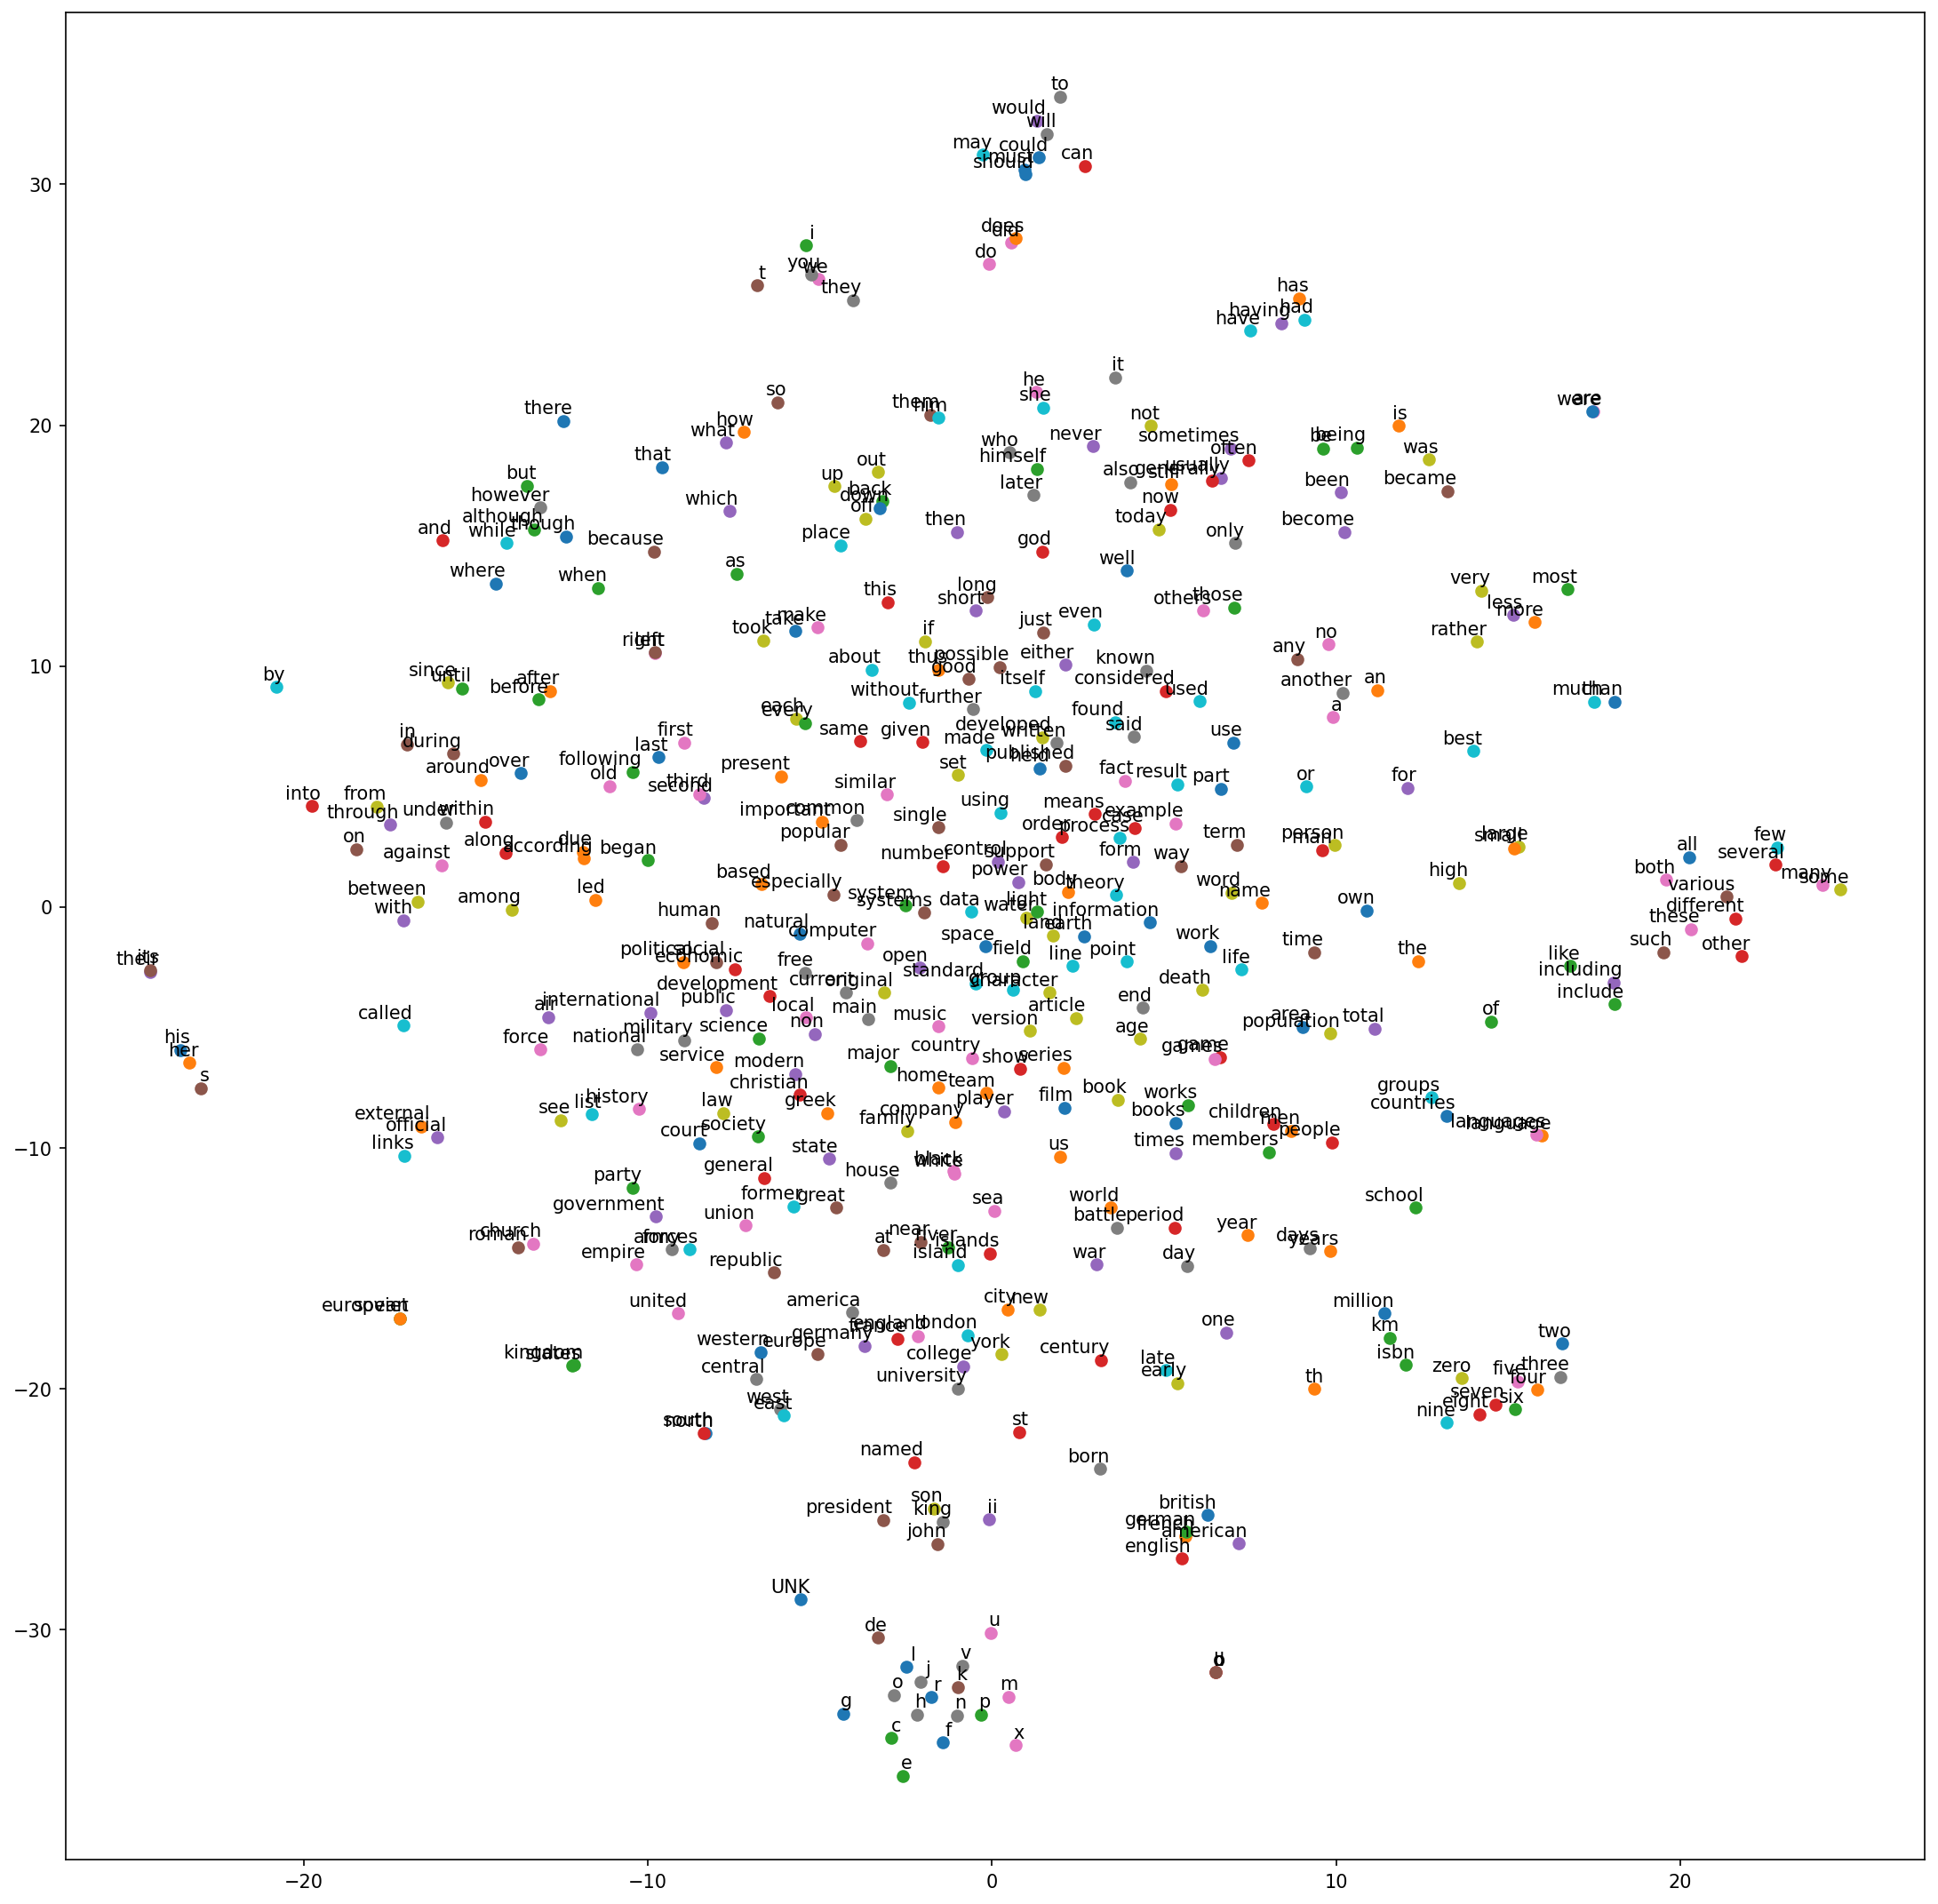

In [96]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact', learning_rate='auto')
plot_only = 400
final_embeddings = embedding_matrix
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [id_to_word[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

### 4. Show top-5 nearest neighbors of two words.(pick by yourself)

In [97]:
top_k_nearest('power', 5)
top_k_nearest('party', 5)

---top 5 nearest words of power---
power
authority
potential
freedom
weight


---top 5 nearest words of party---
party
parties
republican
liberal
democratic


